# First test

In [ ]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### API Guide ###
"""
The following link explains how the API works, as well as lists the Fields (columns) obtainable.
"""


### Report Codes ###

# Disaggregated Futs + Options: kh3c-gbw2; Futs-onl: 6dca-aqww
# Index Traders Report: j7hz-qgms

# CFTC Disaggregated COT (Futs + Options) dataset
BASE_URL = "https://publicreporting.cftc.gov/resource/kh3c-gbw2.json"

params = {
    "$limit": 1,                       # most recent row
    "$order": "report_date_as_yyyy_mm_dd DESC",
    "market_and_exchange_names": "CORN - CHICAGO BOARD OF TRADE"
}

resp = requests.get(BASE_URL, params=params)
resp.raise_for_status()
data = resp.json()

# Build DataFrame
df = pd.DataFrame(data)

df_mm = df[[
    "report_date_as_yyyy_mm_dd",
    "m_money_positions_long_all",
    "m_money_positions_short_all"
]].copy()

df_mm["m_money_net_all"] = (
    df_mm["m_money_positions_long_all"].astype(int)
    - df_mm["m_money_positions_short_all"].astype(int)
)

df_mm


,report_date_as_yyyy_mm_dd,m_money_positions_long_all,m_money_positions_short_all,m_money_net_all
0,2026-01-27T00:00:00.000,216856,288906,-72050


## Building historical Data repository

### Helper Function

In [5]:
def fetch_cot_history(
        market_name: str,
        start_date: str,
        dataset_id: str = "kh3c-gbw2",
        limit: int = 50000
):
    base_url = f"https://publicreporting.cftc.gov/resource/{dataset_id}.json"

    params = {
        "market_and_exchange_names": market_name,
        "$where": f"report_date_as_yyyy_mm_dd >= '{start_date}'",
        "$limit": limit,
        "$order": "report_date_as_yyyy_mm_dd ASC"
    }

    r = requests.get(base_url, params=params)
    r.raise_for_status()
    data = r.json()

    return pd.DataFrame(data)

### Define markets & date window

In [6]:
start_date = "2009-01-01"

markets = {
    "Corn": "CORN - CHICAGO BOARD OF TRADE",
    "Soybeans": "SOYBEANS - CHICAGO BOARD OF TRADE",
    "Soybean Oil": "SOYBEAN OIL - CHICAGO BOARD OF TRADE",
    "Soybean Meal": "SOYBEAN MEAL - CHICAGO BOARD OF TRADE",
    "Cotton": "COTTON NO. 2 - ICE FUTURES U.S."
}

### Fetching Data

In [7]:
df_corn = fetch_cot_history(markets["Corn"], start_date)
df_cotton = fetch_cot_history(markets["Cotton"], start_date)
df_soybeans = fetch_cot_history(markets["Soybeans"], start_date)
df_sbo = fetch_cot_history(markets["Soybean Oil"], start_date)
df_sbm = fetch_cot_history(markets["Soybean Meal"], start_date)

print(len(df_corn), "corn rows")
print(len(df_cotton), "cotton rows")

891 corn rows
891 cotton rows


In [9]:
output_file = "CFTC_Disaggregated_COT_Ags.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_corn.to_excel(writer, sheet_name="Corn", index=False)
    df_cotton.to_excel(writer, sheet_name="Cotton", index=False)
    df_soybeans.to_excel(writer, sheet_name="Soybeans", index=False)
    df_sbo.to_excel(writer, sheet_name="SBO", index=False)
    df_sbm.to_excel(writer, sheet_name="SBM", index=False)

output_file


'CFTC_Disaggregated_COT_Ags.xlsx'

### Automatically updating CoT database

In [12]:
def update_cot_data(existing_df, market_name, dataset_id="kh3c-gbw2"):
    last_date = existing_df["report_date_as_yyyy_mm_dd"].max()

    base_url = f"https://publicreporting.cftc.gov/resource/{dataset_id}.json"
    params = {
        "market_and_exchange_names": market_name,
        "$where": f"report_date_as_yyyy_mm_dd > '{last_date}'",
        "$order": "report_date_as_yyyy_mm_dd ASC"
    }

    r = requests.get(base_url, params=params)
    r.raise_for_status()
    new_data = pd.DataFrame(r.json())

    if new_data.empty:
        return existing_df

    return pd.concat([existing_df, new_data], ignore_index=True)


def update_all_markets(file_path, markets, ref_market="Corn"):
    # load reference market
    df_ref = pd.read_excel(file_path, sheet_name=ref_market)
    last_date = df_ref["report_date_as_yyyy_mm_dd"].max()

    # check if new data exists
    base_url = "https://publicreporting.cftc.gov/resource/kh3c-gbw2.json"
    params = {
        "market_and_exchange_names": markets[ref_market],
        "$where": f"report_date_as_yyyy_mm_dd > '{last_date}'",
        "$limit": 1
    }

    r = requests.get(base_url, params=params)
    r.raise_for_status()

    if not r.json():
        print("No new COT release yet.")
        return

    # update all markets
    updated_dfs = {}
    for name, market in markets.items():
        df_old = pd.read_excel(file_path, sheet_name=name)
        updated_dfs[name] = update_cot_data(df_old, market)

    # write everything back
    with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
        for name, df in updated_dfs.items():
            df.to_excel(writer, sheet_name=name, index=False)

    print("All markets updated.")

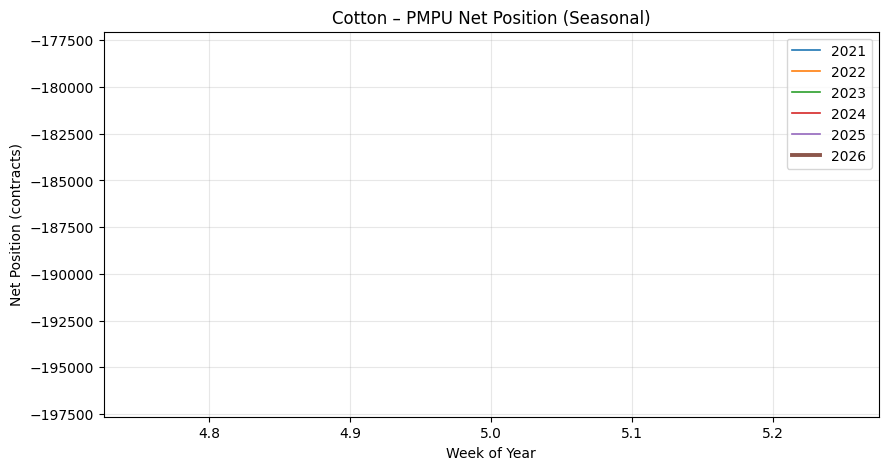

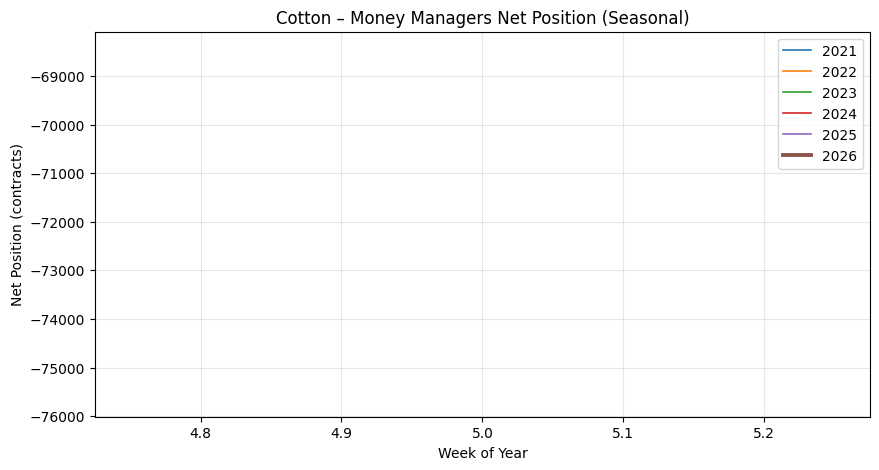

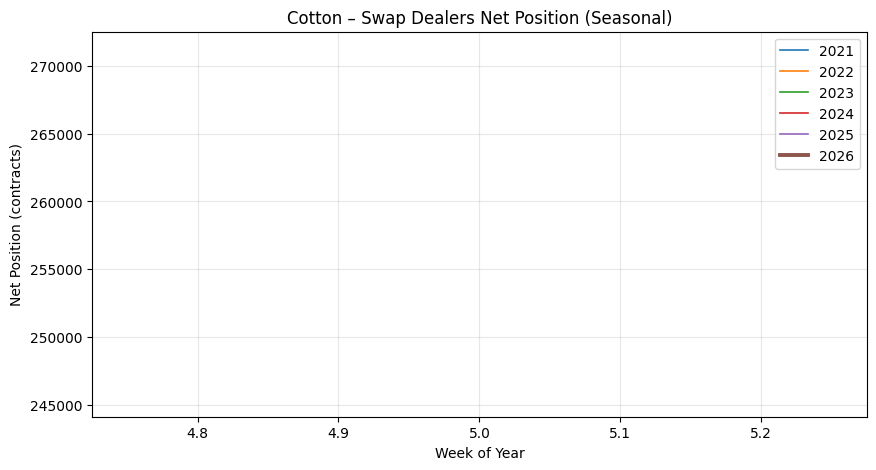

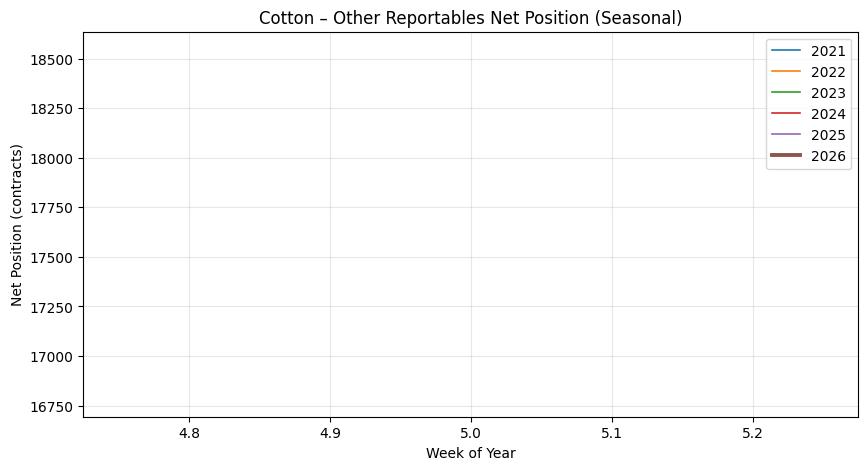

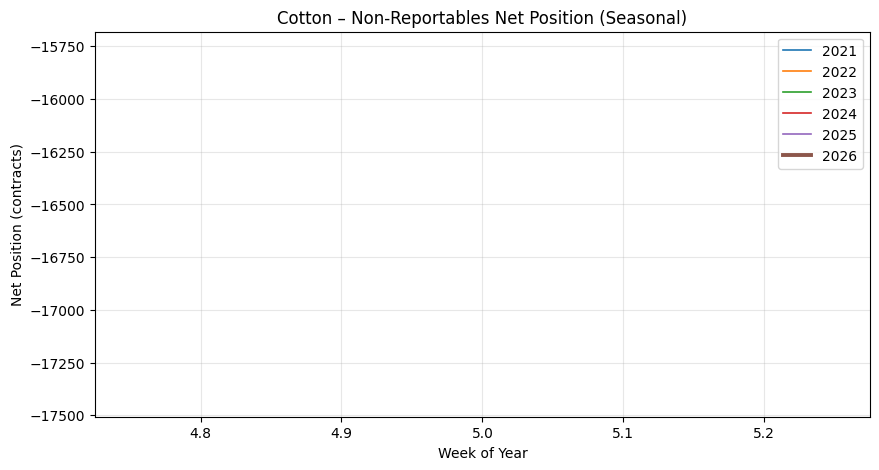

In [20]:

df["date"] = pd.to_datetime(df["report_date_as_yyyy_mm_dd"])
df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week.astype(int)

current_year = df["year"].max()
years = list(range(current_year - 5, current_year + 1))
df = df[df["year"].isin(years)]

nets = {
    "PMPU": df["prod_merc_positions_long"].astype(int)
            - df["prod_merc_positions_short"].astype(int),

    "Money Managers": df["m_money_positions_long_all"].astype(int)
            - df["m_money_positions_short_all"].astype(int),

    "Swap Dealers": df["swap_positions_long_all"].astype(int)
            - df["swap__positions_short_all"].astype(int),

    "Other Reportables": df["other_rept_positions_long"].astype(int)
            - df["other_rept_positions_short"].astype(int),

    "Non-Reportables": df["nonrept_positions_long_all"].astype(int)
            - df["nonrept_positions_short_all"].astype(int),
}


for name, net in nets.items():
    plt.figure(figsize=(10, 5))

    df_plot = df.copy()
    df_plot["net"] = net

    for y in years:
        tmp = df_plot[df_plot["year"] == y]
        tmp = tmp.groupby("week")["net"].mean()

        lw = 2.8 if y == current_year else 1.2
        plt.plot(tmp.index, tmp.values, label=str(y), linewidth=lw)

    plt.title(f"Cotton – {name} Net Position (Seasonal)")
    plt.xlabel("Week of Year")
    plt.ylabel("Net Position (contracts)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()